# Titanic Challenge - Univariate Analysis

The objective of this explorative analysis will be to try to find patterns that predict the survival of a passenger on the Titanic. To achieve this, we must begin by organizing the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from IPython.display import display

%matplotlib inline

# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender = pd.read_csv('gender_submission.csv')

# Print the shape of the dataset (lines, columns)
print('\nData shape: ', train.shape)
        
# Count duplicated rows
df = pd.DataFrame(train)
bool_series = df.duplicated(keep ='first')
print('\nNumber of duplicated rows: ', sum(bool_series))

# Count the missing values in each column
print('\nMissing Values in each column:')
for col in train.columns:
    missing_train = train[col].isnull().sum()
    if missing_train > 0:
        print('\n\t',col, missing_train, "{0:.2%}".format(missing_train / train.shape[0]))

# Count the distinct values in each column
print('\nNumber of unique values in each column:\n')
index = 0
for col in train.nunique():
    print('\tColumn', index, ': ', col)
    index += 1


Data shape:  (891, 12)

Number of duplicated rows:  0

Missing Values in each column:

	 Age 177 19.87%

	 Cabin 687 77.10%

	 Embarked 2 0.22%

Number of unique values in each column:

	Column 0 :  891
	Column 1 :  2
	Column 2 :  3
	Column 3 :  891
	Column 4 :  2
	Column 5 :  88
	Column 6 :  7
	Column 7 :  7
	Column 8 :  681
	Column 9 :  248
	Column 10 :  147
	Column 11 :  3


In [2]:
sum(train.iloc[:,9].duplicated())

643

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Survival Rate

The most elementary statistic we can do is determine the survival rate for a passenger, irrespective of their characteristics.

In [4]:
survivorq = train.loc[:, 'Survived'].value_counts()
survivorq_perc = train.loc[:, 'Survived'].value_counts() / train.shape[0]
print('Survival counts:\n', survivorq)
print('Survival percentage:\n', survivorq_perc)


Survival counts:
 0    549
1    342
Name: Survived, dtype: int64
Survival percentage:
 0    0.616162
1    0.383838
Name: Survived, dtype: float64


So, we have an average survival rate of <b>38.4%</b>. Now, let us compare the survival rate of people grouped by the different characteristics outlined in each column of the dataset.

- <b>Ticket class (`Pclass`)</b>: <i>What if the richer class is better favored?</i>
    
- <b>`Sex`</b>: <i>What if women are better favored?</i>
    
- <b>`Age`</b>: <i>What if the young and elderly are better favored?</i>
    
- <b>If they have siblings/spouses on board (`SibSp`)</b>: <i>What if a parent with a child is better favored?</i>
    
- <b>If they have parents/children on board (`ParCh`)</b>: <i>If children are favored, wouldn't it make sense for at least one parent to be saved as well?</i>
    
- <b>Cost of the ticket (`Fare`)</b>: <i>Is the price of a fare related to privileges in an emergency situation?</i>




Let us verify each one of these hypotheses.

In [57]:
# Survivor filter
surv = train['Survived'].isin(train.loc[train['Survived'] == 1, 'Survived'])

### Sex

In James Cameron's famous movie, women were one of the better favored groups to leave the Titanic before others.

In [6]:
# Distinguished by sex
sex_pass = train['Sex'].value_counts()

# Survivors by sex
s_sex_pass = train.loc[surv, 'Sex'].value_counts()

perc_s_sex = s_sex_pass / sex_pass * 100
perc_s_sex

female    74.203822
male      18.890815
Name: Sex, dtype: float64

In [7]:
print('Survival rate of female passengers:', perc_s_sex.iloc[0], '\nSurvival rate of male passengers:' , perc_s_sex.iloc[1])

Survival rate of female passengers: 74.20382165605095 
Survival rate of male passengers: 18.890814558058924


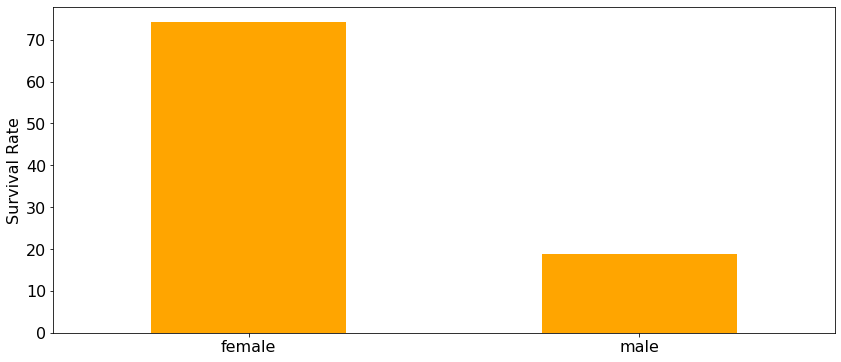

In [8]:
# Change font size
SMALL_SIZE = 16
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

# Plot figure
ax = perc_s_sex.plot.bar(rot = 0, color = "orange", figsize = (14,6))
plt.ylabel("Survival Rate")
plt.show()

The above numbers and graph show us that women were indeed highly favored above men.

### Class

Status tends to play a significant role in all kinds of areas. Aboard the Titanic, we'd expect nothing different. That is, the type of ticket might include evacuation privileges in the event of a disaster. To verify this hypothesis, we group the passengers in terms of class.

In [9]:
# Passengers grouped by class
pcl_pass = train['Pclass'].value_counts()

# Survivors grouped by class
s_pcl_pass = train.loc[surv,'Pclass'].value_counts()

In [10]:
perc_s_pcl = s_pcl_pass/ pcl_pass * 100

In [11]:
for x in range(0,3):
    print('Survival rate of class', x + 1, ':', perc_s_pcl.iloc[x])

Survival rate of class 1 : 62.96296296296296
Survival rate of class 2 : 47.28260869565217
Survival rate of class 3 : 24.236252545824847


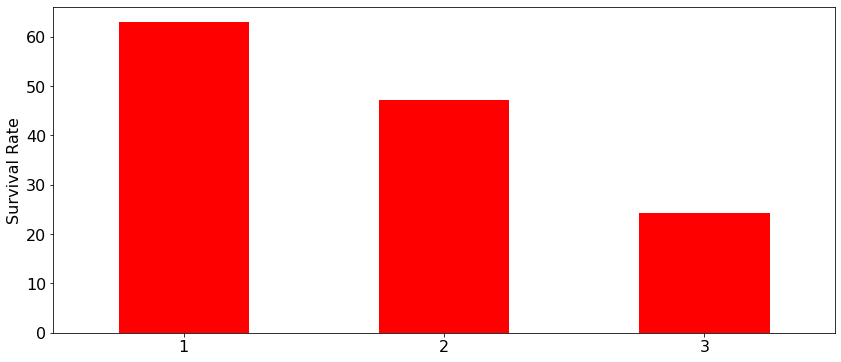

In [12]:
ax = perc_s_pcl.plot.bar(rot = 0, color = "Red", figsize = (14,6))
plt.ylabel("Survival Rate")
plt.show()

As expected, we see that higher classes are better favored.

### Age

Since age is a quantity that varies a lot across the passengers, we shall study this quantity in terms of the following age bins:

- <b>Children-Early Teens (0-14)</b>

- <b>Teens-Young Adults (15-24)</b>

- <b>Adults (25-64)</b>

- <b>Elderly (65+)</b>

The reason for this choice is simply to connect survivability with the age bins of cultural significance of the time. One was considered a child until they were 15, young adults until 25, and so on. 

In [13]:
# Creating age bins
age_pass = pd.cut(train['Age'], bins = [0,14,24,64, max(train['Age']) + 0.001], include_lowest = True)

# Passengers grouped by age bins
age_pass = age_pass.value_counts()

# Survivors grouped by age bins
s_age_pass = pd.cut(train.loc[surv, 'Age'], bins = [0,14,24,64, max(train['Age']) + 0.001], include_lowest = True)
s_age_pass = s_age_pass.value_counts()

# Survival rate
perc_s_age = s_age_pass / age_pass * 100
perc_s_age = perc_s_age.sort_index()

In [14]:
bin = ['0-14', '15-24', '25-64', '65+']
for x in range(0,len(bin)):
    print('Survival rate of ages', bin[x], ':', perc_s_age.iloc[x])

Survival rate of ages 0-14 : 58.44155844155844
Survival rate of ages 15-24 : 36.5
Survival rate of ages 25-64 : 40.140845070422536
Survival rate of ages 65+ : 9.090909090909092


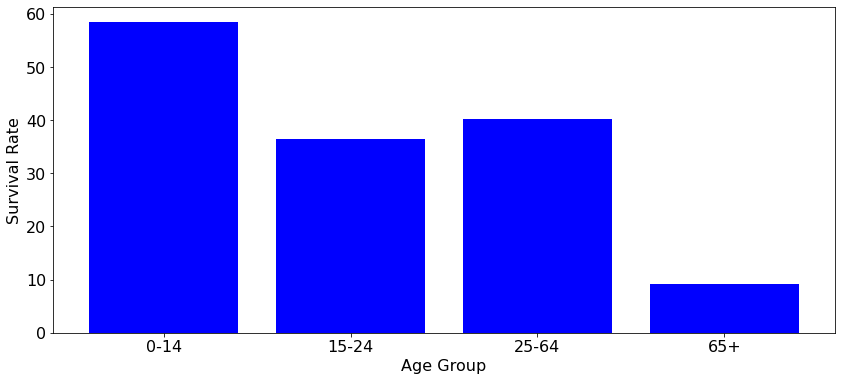

In [15]:
x = ['0-14', '15-24', '25-64', '65+']

plt.figure(figsize = (14,6))
plt.bar(x, perc_s_age, color = 'blue')
plt.ylabel("Survival Rate")
plt.xlabel("Age Group")
plt.show()

The survival rate is highest among youngsters and lowest for the elderly. In a very naturalistic sense, this would indicate that people with higher life expectancy are - on average - better favored.

However, the slight favor of adults compared to teenagers contradicts this more naturalistic argument. A possible explanation might be that, in times of peril, adults are more resourceful than teenagers. For example, the row-boats were most likely operated by adults rather than teenagers/young adults.

In addition, this difference might be caused by other factors, such as the accumulation of more wealth within the 25-64 age group, which - as we have seen in the `Pclass` analysis - increases the chances of survival (assuming, of course, the logical sense that higher ticket classes are more expensive than lower class tickets).

### SibSp

Familial ties may also play a role in survivability. However, contrary to the other characteristics we've worked with so far, we don't have a clear expectation and/or hypothesis for how this affects the survival rate. In an emergency setting, would the evacuation policy have a predilection for families at once? Or do they prefer to diversify the survivors, as to not apply favoritism to specific families?

Let's figure it out.

In [16]:
sibsp_pass = train['SibSp'].value_counts().sort_index()
sibsp_pass

0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: SibSp, dtype: int64

There are 7 groups within this column, which shall be the bins we use to calculate the survival rates.

In [17]:
d_sibsp_pass = train.loc[~surv, 'SibSp'].value_counts().sort_index()
s_sibsp_pass = sibsp_pass - d_sibsp_pass

perc_s_sibsp = s_sibsp_pass / sibsp_pass * 100
perc_s_sibsp = perc_s_sibsp.replace(np.nan, 0)

In [18]:
for x in range(0, len(sibsp_pass)):
    print('Survival rate of ', perc_s_sibsp.index[x], 'sibling(s) and/or spouse:', perc_s_sibsp.iloc[x])

Survival rate of  0 sibling(s) and/or spouse: 34.53947368421053
Survival rate of  1 sibling(s) and/or spouse: 53.588516746411486
Survival rate of  2 sibling(s) and/or spouse: 46.42857142857143
Survival rate of  3 sibling(s) and/or spouse: 25.0
Survival rate of  4 sibling(s) and/or spouse: 16.666666666666664
Survival rate of  5 sibling(s) and/or spouse: 0.0
Survival rate of  8 sibling(s) and/or spouse: 0.0


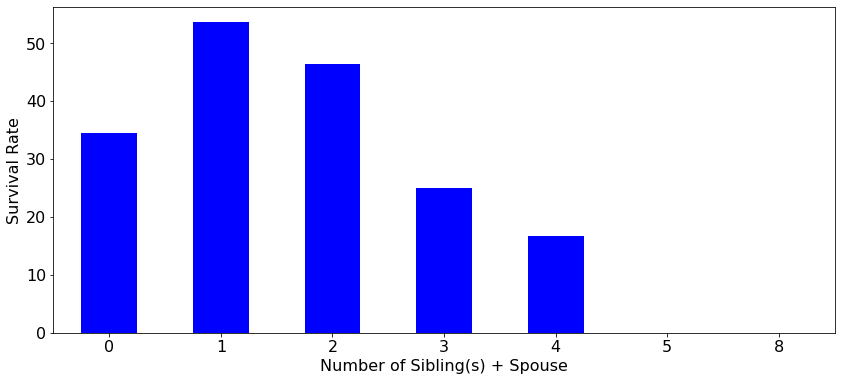

In [19]:
ax = perc_s_sibsp.plot.bar(rot = 0, color = 'blue', figsize = (14,6))
plt.ylabel("Survival Rate")
plt.xlabel("Number of Sibling(s) + Spouse")
plt.show()

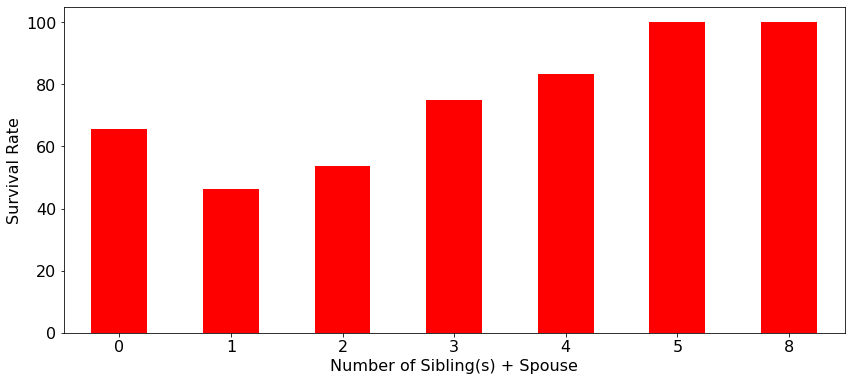

In [20]:
perc_d_sibsp = d_sibsp_pass / sibsp_pass * 100

ax = perc_d_sibsp.plot.bar(rot = 0, color = 'red', figsize = (14,6))
plt.ylabel("Survival Rate")
plt.xlabel("Number of Sibling(s) + Spouse")
plt.show()

Because there 0 survivors in some categories, perhaps it might be useful to use stacked graphs.

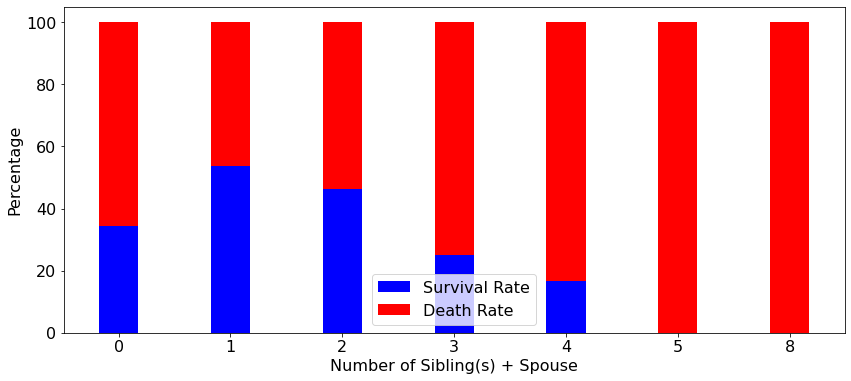

In [21]:
labels = ['0','1','2','3','4','5','8']
y0 = perc_s_sibsp
y1 = perc_d_sibsp
width = 0.35       

# the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize = (14,6))

ax.bar(labels, y0, width, color = 'b', label="Survival Rate")
ax.bar(labels, y1, width, color = 'r', label='Death Rate',  bottom = y0)

ax.set_ylabel('Percentage')
ax.set_xlabel('Number of Sibling(s) + Spouse')
ax.legend()

plt.show()

The only reason we included this extra plot is to show that the survival rate is 0% for the numbers 5 and 8, and not an error in our plot of the data.

What we find from these graphs is that the survival rate is maximum at 1 and slowly decreases to 0 as the family size increases. The reason behind this behavior might be that potential survivors refused to leave the vessel because they didn't want to leave their families behind. That is, while they themselves were eligible to leave the Titanic, their family members were not.

The maximum at 1 might be that, although large families occupy too much space, it is very little effort for two siblings or a husband and wife to evacuate together. Might even be possible to extrapolate the number of passengers in each row-boat by 1, without a problem. 

### Parch

Compared to the `SibSp` column, the Parent/Child (`Parch`) relation is one of much higher dependency. That is, if a child is evacuated, it would be interesting to pair them with at least one of the two parents. Futhermore, given the analysis in the `Sex` column highly favoring women, we'd expect women would have a very high survival rate in this setting. However, we leave this final hypothesis to be discussed in the eventual bivariate analysis, which shall be done in another notebook.

For now, we shall repeat the same style of analysis as was done with the `SibSp` column.

In [58]:
parch_pass = train['Parch'].value_counts().sort_index()
s_parch_pass = train.loc[surv, 'Parch'].value_counts().sort_index()
d_parch_pass = train.loc[~surv, 'Parch'].value_counts().sort_index()

perc_d_parch = d_parch_pass / parch_pass * 100
perc_s_parch = s_parch_pass / parch_pass * 100
perc_s_parch = perc_s_parch.replace(np.nan, 0)

perc_s_parch

0    34.365782
1    55.084746
2    50.000000
3    60.000000
4     0.000000
5    20.000000
6     0.000000
Name: Parch, dtype: float64

In [59]:
perc_d_parch

0     65.634218
1     44.915254
2     50.000000
3     40.000000
4    100.000000
5     80.000000
6    100.000000
Name: Parch, dtype: float64

In [60]:
for x in range(0, len(parch_pass)):
    print('Survival rate of ', perc_s_parch.index[x], 'parent(s) and/or child(ren):', perc_s_parch.iloc[x])

Survival rate of  0 parent(s) and/or child(ren): 34.365781710914455
Survival rate of  1 parent(s) and/or child(ren): 55.08474576271186
Survival rate of  2 parent(s) and/or child(ren): 50.0
Survival rate of  3 parent(s) and/or child(ren): 60.0
Survival rate of  4 parent(s) and/or child(ren): 0.0
Survival rate of  5 parent(s) and/or child(ren): 20.0
Survival rate of  6 parent(s) and/or child(ren): 0.0


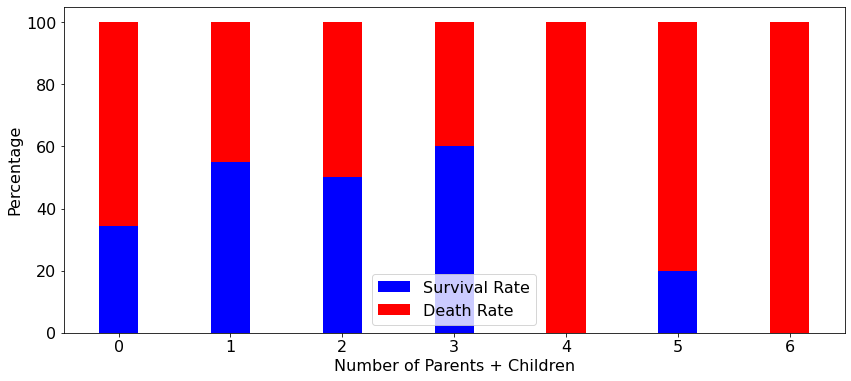

In [25]:
labels = ['0','1','2','3','4','5','6']
y0 = perc_s_parch
y1 = perc_d_parch
width = 0.35       

# the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize = (14,6))

ax.bar(labels, y0, width, color = 'b', label="Survival Rate")
ax.bar(labels, y1, width, color = 'r', label='Death Rate',  bottom = y0)

ax.set_ylabel('Percentage')
ax.set_xlabel('Number of Parents + Children')
ax.legend()

plt.show()

Here the survival doesn't have such a regular tendency. Furthermore, while we observe 0% survival rate at 4 and 6, we see 20% at 5. Looking at the number of people in each category, we find that this result might be an outlier, since only a single person with 5 parents+children survived.

To develop a specific understanding of why this person survived, let us identify them.

In [26]:
parch_pass

0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: Parch, dtype: int64

In [27]:
train.loc[surv & (train['Parch'] == 5), :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S


So, it is a female with a spouse onboard, with 2/1/0 parents and 3/4/5 children. We note also that this person is in the least favored class of survival and the second-favored age bin. Let us see if her husband survived.

In [63]:
strr = 'Asplund'
Asplund_pass = []
for x in train['Name']:
    for y in range(0, len(strr)):
        if x[y] != strr[y]:
            break
        if y == len(strr) - 1:
            Asplund_pass.append(train.loc[train['Name'] == x, 'PassengerId'].index[0] + 1)
Asplund_pass

[26, 183, 234, 262]

In [64]:
Asplund_filter = train['PassengerId'].isin(Asplund_pass)
Asplund_family = train.loc[Asplund_filter, :]
Asplund_family

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S
182,183,0,3,"Asplund, Master. Clarence Gustaf Hugo",male,9.0,4,2,347077,31.3875,NaN,S
233,234,1,3,"Asplund, Miss. Lillian Gertrud",female,5.0,4,2,347077,31.3875,NaN,S
261,262,1,3,"Asplund, Master. Edvin Rojj Felix",male,3.0,4,2,347077,31.3875,NaN,S


In [32]:
Asplund_family.iloc[0]['Name']

'Asplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson)'

We found the Asplund family, but no sign of Selma's spouse. From a Google search, we found that he was in fact one of the victims of the Titanic and that his full name is 'Carl Oscar Vilhelm Gustafsson Asplund'. Perhaps his name doesn't start with Asplund in the registry. Let us try his other last names.

In [65]:
strr = 'Vilhelm'
Vilhelm_pass = []
for x in train['Name']:
    for y in range(0, len(strr)):
        if x[y] != strr[y]:
            break
        if y == len(strr) - 1:
            Vilhelm_pass.append(train.loc[train['Name'] == x, 'PassengerId'].index[0] + 1)

strr = 'Gustafsson'
Gustafsson_pass = []
for x in train['Name']:
    for y in range(0, len(strr)):
        if x[y] != strr[y]:
            break
        if y == len(strr) - 1:
            Gustafsson_pass.append(train.loc[train['Name'] == x, 'PassengerId'].index[0] + 1)
            
strr = 'Oscar'
Oscar_pass = []
for x in train['Name']:
    for y in range(0, len(strr)):
        if x[y] != strr[y]:
            break
        if y == len(strr) - 1:
            Oscar_pass.append(train.loc[train['Name'] == x, 'PassengerId'].index[0] + 1)

In [66]:
Vilhelm_pass

[]

In [67]:
Gustafsson_pass
Gustafsson_filter = train['PassengerId'].isin(Gustafsson_pass)
train.loc[Gustafsson_filter, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
104,105,0,3,"Gustafsson, Mr. Anders Vilhelm",male,37.0,2,0,3101276,7.9250,NaN,S
379,380,0,3,"Gustafsson, Mr. Karl Gideon",male,19.0,0,0,347069,7.7750,NaN,S
392,393,0,3,"Gustafsson, Mr. Johan Birger",male,28.0,2,0,3101277,7.9250,NaN,S
876,877,0,3,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,7534,9.8458,NaN,S


In [36]:
Oscar_pass
Oscar_filter = train['PassengerId'].isin(Oscar_pass)
train.loc[Oscar_filter, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [37]:
train.loc[train['Ticket'] == Asplund_family.iloc[0]['Ticket'], :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S
182,183,0,3,"Asplund, Master. Clarence Gustaf Hugo",male,9.0,4,2,347077,31.3875,NaN,S
233,234,1,3,"Asplund, Miss. Lillian Gertrud",female,5.0,4,2,347077,31.3875,NaN,S
261,262,1,3,"Asplund, Master. Edvin Rojj Felix",male,3.0,4,2,347077,31.3875,NaN,S


We conclude, then, that Mr. Asplund is not present in the dataset, yet he appears implicitly through both the `SibSp` and `Parch` columns. This must also be the case for other passengers, since 2240 people were aboard the Titanic, yet our dataset contains only 891 entries.

From a Google search, we found that he died in the Titanic disaster, which is consistent with the hypothesis that having a child increases the surivability of the female parent. We shall pry into this matter further in the bivariate analysis.

Furthermore, it might be interesting to distinguish parents from children. That is, count the number of families (people with the same last names) and break them into categories of parents and children. The reason that this separation might be possible is due to the clear age gaps we expect to find between the parents and children. For example, we could calculate 'Age - 18' of people with 'Parch >= 1', grouped by surname. The passengers whose 'Age - 18' are larger or equal to the at least one of the smaller ages in the family would indicate a parent. For example:

`Smith_Family_Name` = [John, Mary, Zach, Amy]
`Smith_Family_Age` = [48 , 35, 10, 12]

`Smith_Family_Age - 18` = [30 , 17, -8, -6]

Since 30 and 17 are both larger or equal to 10 and 12 (Zach and Amy's ages), these are the parents. The question is whether all children within our dataset has at least one parent present in the dataset. It might be that, just as Selma Asplund's husband is missing from the dataset, we could find a group of siblings without a parent. Treating this case through the same example, we'd find:

`Smith_Family_Name` = [Zach, Amy]
`Smith_Family_Age` = [10, 12]

`Smith_Family_Age - 18` = [-8, -6]

Since -6 is not larger or equal to 10, then we find no parents. One drawback might be when we have a family sibling as well. In this case, we might erroneously identify 3 parents instead of 2. We shall return to this idea in the bivariate analysis. 

### Fare

Along the lines of the analysis of the Ticket Class (`Pclass` column), we expect higher fares to be related to more favorable condiitons in times of disaster aboard the ship. We'd also expect these two variables to share a certain degree of correlation with each other, since higher class tickets are most certainly pricier than lower class tickets.

Let us begin by identifying standard ticket values.

In [38]:
train['Fare'].value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: Fare, Length: 248, dtype: int64

248 ticket fares distributed among 891 people. This means many of the tickets had a standard value. However, given that the variation of this quantity is continuous (floating values) it will be more interesting to generate a statistical description of the fares.

In [70]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

The tickets vary from \\$0.00 to \\$512.33, with a mean of \\$(32.20 +/- 24.85). Based on these values, let us separate the fares into bins of \\$0 to \\$7.35(=32.20 - 24.85), \\$7.35 to \\$32.20, \\$32.20 to \\$57.05(=32.20 + 24.85) and \\$57.05 to \\$512.00.

In [75]:
train_mean = train['Fare'].mean()
train_std = train['Fare'].std()

ticket_pass = pd.cut(train['Fare'], bins = [0, train_mean - train_std / 2, train_mean, train_mean + train_std / 2, max(train['Fare']) + 0.001], include_lowest = True)
ticket_pass = ticket_pass.value_counts()

s_ticket_pass = pd.cut(train.loc[surv, 'Fare'], bins = [0, train_mean - train_std / 2, train_mean, train_mean + train_std / 2, max(train['Fare']) + 0.001], include_lowest = True)
s_ticket_pass = s_ticket_pass.value_counts()

perc_s_ticket = s_ticket_pass / ticket_pass * 100

In [79]:
perc_s_ticket = perc_s_ticket.sort_values()
for x in range(0, len(perc_s_ticket)):
    print('Survival rate of passengers with ticket fares in the interval', perc_s_ticket.index[x], ':', perc_s_ticket.iloc[x])

Survival rate of passengers with ticket fares in the interval (-0.001, 7.357] : 13.095238095238097
Survival rate of passengers with ticket fares in the interval (7.357, 32.204] : 34.395973154362416
Survival rate of passengers with ticket fares in the interval (32.204, 57.051] : 47.674418604651166
Survival rate of passengers with ticket fares in the interval (57.051, 512.33] : 68.0


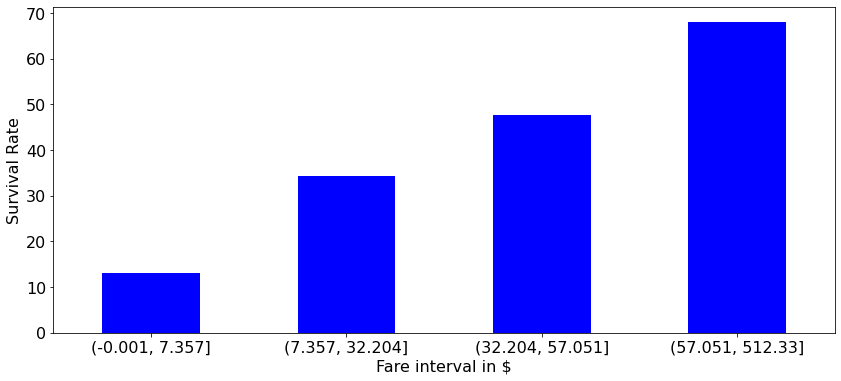

In [80]:
ax = perc_s_ticket.plot.bar(rot = 0, color = 'blue', figsize = (14,6))
plt.ylabel("Survival Rate")
plt.xlabel("Fare interval in $")
plt.show()


In [83]:
ticket_pass = ticket_pass.sort_index()
ticket_pass

(-0.001, 7.357]      84
(7.357, 32.204]     596
(32.204, 57.051]     86
(57.051, 512.33]    125
Name: Fare, dtype: int64

There is irrefutable evidence that the ticket fare influences the survival chances aboard the Titanic. From as low as <b>13.1%</b> to as high as <b>68.0%</b>.

#### Free ticket passengers

This part of the analysis is dedicated to a group of people with a peculiar characteristic: \\$0.00 ticket fares. The reason this group of people might be interesting to investigate is that free ticket passengers are, possibly, people involved with the ship crew, people who helped design the Titanic, etc. In other words, people with a strong attachment and/or duty to the Titanic. 

How this would affect the survival rate of said passengers is something we shall investigate in the following analysis.

In [44]:
train.loc[train.Fare == 0.0, ['Pclass', 'Fare']].groupby('Pclass').value_counts()

Pclass  Fare
1       0.0     5
2       0.0     6
3       0.0     4
dtype: int64

We have 15 passengers that did not pay fairs. Furthermore, they weren't all low class workers. A third of the group is composed of high status people.

In [45]:
train.loc[train.Fare == 0.0,:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


We further note that all these passengers are male and all of them embarked in Southampton. Upon research in Google, we find some additional pieces of information. First, the reason some of these have 'LINE' tickets is due to their affiliation with a New York ship company, the 'American Line'. This was confirmed by searching, in Google, the name of the one survivor among these passengers - Mr. William Henry Tornquist -, who was employed to the American Line.

In other words, the employees of the American Line were supposed to return to New York in another vessel, but due to a coal strike in Britain, they were awarded free 3rd class tickets to the Titanic.

In [46]:
train.loc[(train.Fare == 0.0) & (train.Ticket == 'LINE'),:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S


In [47]:
train.loc[train.Fare == 0.0, 'Survived'].value_counts() / train.loc[train.Fare == 0.0, 'Survived'].shape[0]

0    0.933333
1    0.066667
Name: Survived, dtype: float64

By researching one of the random passengers among these with free tickets, Mr. Alfred Flemming Cunningham, it was discovered that Alfred was one of the nine-strong "guarantee group" of Harland and Wolff employees chosen to oversee the smooth running of the Titanic's maiden voyage.

The low survival rate for members of this group (<b>6.7%</b>) compared to the average male survival rate (<b>18.9%</b>) might be indicative of either a coincidence or a contractual obligation of these people to remain upon the vessel in case of emergency. Since nobody actually believed the Titanic would sink given its architectural marvel, it is not too much of a stretch to believe that passengers - even those of high status - would accept such unfortunate terms of travel. 

Of course, this behavior might also be due to coincidence, since our sample consists of only 15 people. However, it is still interesting to note that the one survivor among this group had a third class ticket, even though the majority of the group were of higher class.

### Embarked

While the idea that certain ports increase/decrease the survival rate might be at first-hand nonsensical, the idea that first occupants are more/less favored than the final occupants is not. That is, since we have a lot of missing information related to the cabin occupation, the order of boarding might be indicative of who gets out first/last in case of disaster.

The logic behind this is similar to the boarding/exiting process that exists on some planes. The first to leave are those in the premium class, then people are asked to leave in groups of rows. The cabins were possibly used to organize the evacuation of the Titanic and so, assuming there is a correlation between the cabin occupation and the ports where the boarding occurs, we might find a hidden pattern in the study of the `Embarked` column.

The order in which the passengers embarked the titanic was first Southampton, then Cherbourg and lastly Queenstown.

In [48]:
port_pass = train.loc[:, 'Embarked'].value_counts()
s_port_pass = train.loc[train['Survived'] == 1, 'Embarked'].value_counts()

perc_s_port = s_port_pass / port_pass * 100

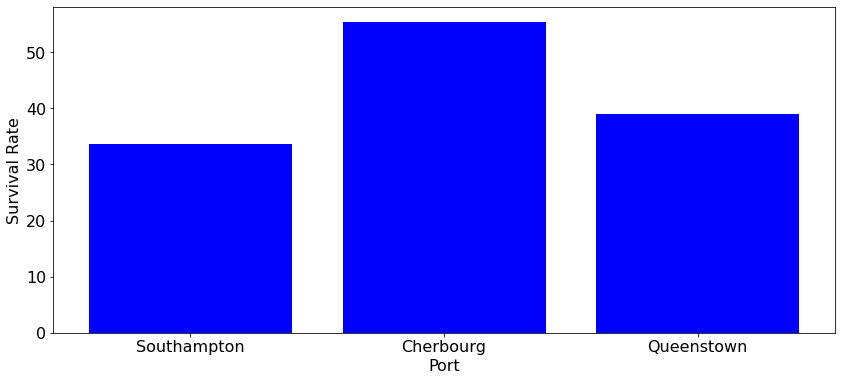

In [49]:
x = ['Southampton', 'Cherbourg', 'Queenstown']
plt.figure(figsize = (14,6))
plt.bar(x, perc_s_port, color = 'blue')
plt.ylabel("Survival Rate")
plt.xlabel("Port")
plt.show()

In [50]:
perc_s_port

S    33.695652
C    55.357143
Q    38.961039
Name: Embarked, dtype: float64

Apparently, the people that embarked in Cherbourg have almost 20% increased survival rate. To be fair, this might actually be caused by a correlation between port and fare price, which itself is an indicator of increased survival rate.

In [51]:
train.loc[: , ['Fare', 'Embarked']].groupby('Embarked').describe()

Fare                                                            \
          count       mean        std     min       25%    50%        75%   
Embarked                                                                    
C         168.0  59.954144  83.912994  4.0125  13.69795  29.70  78.500025   
Q          77.0  13.276030  14.188047  6.7500   7.75000   7.75  15.500000   
S         644.0  27.079812  35.887993  0.0000   8.05000  13.00  27.900000   

                    
               max  
Embarked            
C         512.3292  
Q          90.0000  
S         263.0000

From the statistical description alone, we see that the fares from Cherbourg are, on average, more expensive. This, in turn, might explain the larger survival rate. Let us filter all the fares under $32.2. 

In [96]:
fareport_pass = train.loc[train['Fare'] < 32.2, 'Embarked'].value_counts()
s_fareport_pass = train.loc[(train['Survived'] == 1) & (train['Fare'] < 32.2), 'Embarked'].value_counts()

perc_s_fareport = s_fareport_pass / fareport_pass * 100

In [97]:
fareport_pass

S    511
C     94
Q     75
Name: Embarked, dtype: int64

In [98]:
s_fareport_pass

S    149
C     38
Q     29
Name: Embarked, dtype: int64

In [99]:
perc_s_fareport

S    29.158513
C    40.425532
Q    38.666667
Name: Embarked, dtype: float64

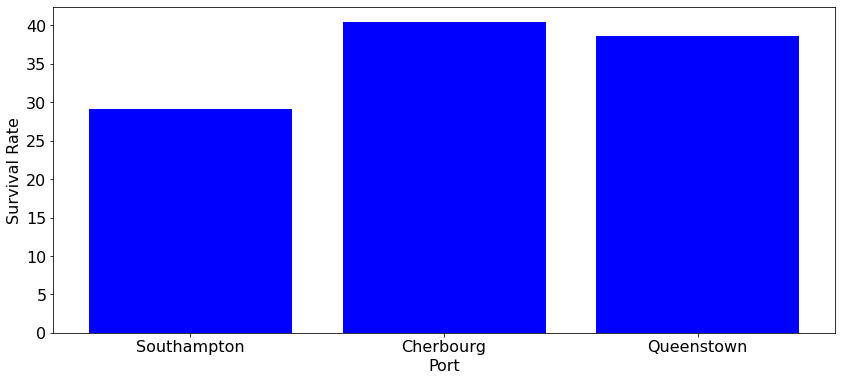

In [100]:
x = ['Southampton', 'Cherbourg', 'Queenstown']
plt.figure(figsize = (14,6))
plt.bar(x, perc_s_fareport, color = 'blue')
plt.ylabel("Survival Rate")
plt.xlabel("Port")
plt.show()

By selecting all the passengers with fares below the average of \\$32.20, we find a more balanced distribution in the survival rates. This is futher evidence for the connection between port and fare.

Furthermore, the fact that Southampton is the first port and has the lowest survival rate might also be evidence that the cabins of the first boarders might be lesser favored in order of evacuation. 

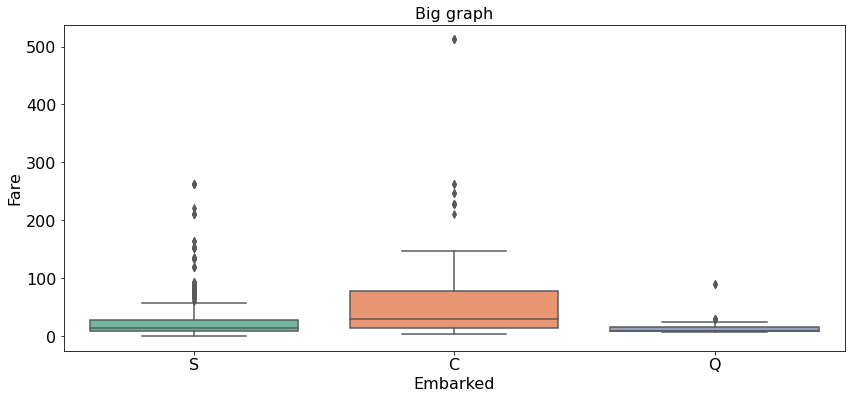

In [102]:
plt.figure(figsize = (14, 6))
plt.title('Big graph')
plt.xlabel('Port')
plt.ylabel('Fare')
ax = sns.boxplot(x = "Embarked", y = "Fare",
                 data = train , palette="Set2")

In the bivariate analysis we shall futher investigate this connection between port and fare cost. For now, it is sufficient to understand that there is a sense to the idea that the first ones to board the Titanic (from Southampton) have smaller survival rates than the rest. Also, there may be a connection between port of embarkment and fare cost, which in turn influences the distinct survival rates for each port.

## Conclusions

From the univariate analysis, we have concluded that:

- Women have much higher chances of survival compared to men (74% vs. 19%).

- The extremal age groups (0-14) and (65+) have the highest (54%) and the lowest survival rates (1 in 11, 9%), respectively.

- The higher the ticket class, the higher the survival rate.

- The higher the SibSp number, the lower the survival rate, reaching 0% for SibSp >= 5.

- The survival rate is highest when Parch is 3, decreasing as one tends to the extremes. Exactly 0% for for Parch = 4 or 6.

- The survival rate is higher the more expensive the ticket fare, with extremes of 13% for fares in the interval [0.00, 7.36] and 68% in the interval [57.00, 513.00]. In addition, there is a group of 15 people with free tickets, which have a very low survival rate (only 1 in 15, 7%).